## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import file
congress_tweets = pd.read_csv("C://Users/mjkeh/CSS_Project5_Team3_Spring2022/data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [3]:
#check the size of the dataset
congress_tweets.shape


(946791, 16)

In [4]:
#subset the data
## fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(frac=0.01, random_state=0)
congress_tweets.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [5]:
#reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index()  #removie missing values
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
1,148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
3,811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [6]:
#check the size of the new dataset
congress_tweets.shape

(9468, 17)

In [7]:
#text data
congress_tweets['text'].head()

0    All of #OH14 salutes you, Patrolman St. Clair!...
1    In Case You Missed It: Bipartisanship works – ...
2    Wishing a happy #Passover to all those celebra...
3    RT @WhiteHouse President @realDonaldTrump just...
4    I just sent a letter demanding the Administrat...
Name: text, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [8]:
#create rem_punc_stop() function
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

# Question!!

the code above involves "spacy_words = [word for word in spacy_words if not word.startswith('http')]", 
so does this mean it already removed all URL?

Also, how can we "identify" and remove "flag for retweeting"?


In [9]:
#use the map() function to apply our rem_punc_stop() function to every row of our dataframe
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # x = each item in the 'text'
congress_tweets['tokens'] # text string -> tokens in list form

0       [All, OH14, salutes, Patrolman, St, Clair, 👮, ...
1       [In, Case, You, Missed, It, Bipartisanship, wo...
2       [Wishing, happy, Passover, celebrating, Seder,...
3       [RT, WhiteHouse, President, realDonaldTrump, s...
4       [I, sent, letter, demanding, Administration, s...
                              ...                        
9463    [Our, greatest, strength, lies, love, RepDebDi...
9464    [RT, davidaxelrod, What, leader, \n, Yes, face...
9465    [RT, tatereeves, The, Chicago, mayor, says, Mi...
9466    [Tomorrow, ElectionDay, Make, sure, voice, heard]
9467    [We, navigating, toughest, challenges, century...
Name: tokens, Length: 9468, dtype: object

In [10]:
congress_tweets['tokens'] [0]

['All',
 'OH14',
 'salutes',
 'Patrolman',
 'St',
 'Clair',
 '👮',
 '\u200d',
 '♂',
 '️',
 'QT',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'Bainbridge',
 'police',
 'officer',
 'day',
 'RooseveltLFOX8']

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1. WordCloud by legislator's political party 

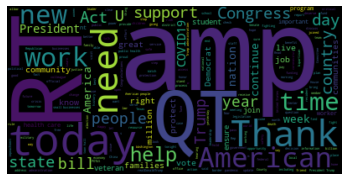

In [11]:
#WordCloud(ALL)

# Convert list of tokens back to text string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud().generate(text) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [12]:
#political party-Republicans

congress_tweets_R = congress_tweets[(congress_tweets['party']=='Republican')]
congress_tweets_R.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[All, OH14, salutes, Patrolman, St, Clair, 👮, ..."
3,811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[RT, WhiteHouse, President, realDonaldTrump, s..."
6,832508,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[RT, HouseGOP, Its, time, holding, China, acco..."
7,586426,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[RT, wdtnews, With, confirmed, COVID19, cases,..."
13,156787,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[There, way, Eric, Swalwell, continue, serve, ..."


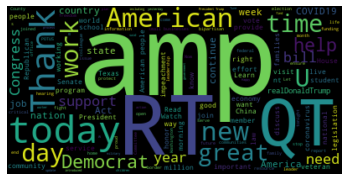

In [13]:
#WordCloud for Republicans

# Convert list of tokens back to text string
text_R = ' '.join(congress_tweets_R['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud().generate(text_R) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [14]:
#political party-Democrats

congress_tweets_D = congress_tweets[(congress_tweets['party']=='Democrat')]
congress_tweets_D.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
1,148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[In, Case, You, Missed, It, Bipartisanship, wo..."
2,373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[Wishing, happy, Passover, celebrating, Seder,..."
4,582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[I, sent, letter, demanding, Administration, s..."
5,860085,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[The, President, attacks, Rep, Ilhan, dishones..."
8,83341,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[RT, SVLeadershipGrp, We, game, changers, acce..."


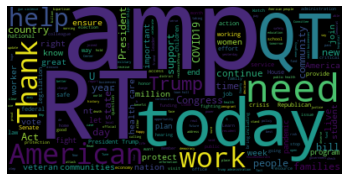

In [15]:
##WordCloud for Democrats
# Convert list of tokens back to text string
text_D = ' '.join(congress_tweets_D['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud().generate(text_D) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Wordcloud shows that the most frequently used words do not vary a lot by party. However, it shows that the republicans use "democrats" frequently, while democrats use "Trump" frequently. 

### EDA 2. Topic modeling : whether the legislator is a Senator or Representative

In [16]:
#create tf-idf matrix
X = congress_tweets['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop) #creating an object : tf model

tfidf_matrix =  tf.fit_transform(X) #downweigh the common words & upweigh the rare words
dense_matrix = tfidf_matrix.todense() #remove all the columns where thre are 0

In [17]:
tfidf_matrix

<9468x26297 sparse matrix of type '<class 'numpy.float64'>'
	with 191804 stored elements in Compressed Sparse Row format>

In [18]:
dense_matrix

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.14701371, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.08333364, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [19]:
#initialize model/ prescecify the parameter n => "10 topics"
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0) #random_state for reproducibility
lda = lda.fit(dense_matrix) # pass through our dense matrix

In [20]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [21]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
wishing 
 christmas text happy tropical junk merry memorialday park enterprise hhs suffer rx celebrating storm coast hurricane ended sufficient

Topic #1:
dejoy reasons male outcome happythanksgiving lakes postmaster goptaxscam uscg gunviolence markup detained fails stake equal rt attempted site priority cumulative

Topic #2:
schiff adam ambassador articles hong collusion defendourdemocracy kong ccp dosomething african lied tps facts borders elijah false buildthewall rhetoric repdavids

Topic #3:
😷 foxnews ill god succeed govmikedewine seanhannity tune lake est ginsburg 430 iowa wearing mandate az05 hanukkah mask island facts

Topic #4:
👏 presidents ads urban recession park survey lot allocate reproybalallard randpaul hotline pt finding insecurity map tv wsj baldwin preparing

Topic #5:
king stem advice luther idaho martin jr mlkday normandy steve sacred allied answering liar sweet premiums urges celebrates boeing smallbusinesssaturday

Topic #6:
de la el y en para que los d

In [22]:
#get the topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.01918202, 0.0191817 , 0.0191843 , ..., 0.01918315, 0.31300409,
        0.01918593],
       [0.28974522, 0.02395118, 0.02395077, ..., 0.02395074, 0.51864332,
        0.0239548 ],
       [0.02958227, 0.02958536, 0.02958057, ..., 0.02957108, 0.42197058,
        0.3414217 ],
       ...,
       [0.01399589, 0.01399418, 0.01399595, ..., 0.4524316 , 0.43560515,
        0.01400146],
       [0.22464725, 0.03138895, 0.03138895, ..., 0.03138895, 0.03139862,
        0.5242284 ],
       [0.02297857, 0.02297857, 0.02298043, ..., 0.02297857, 0.02298386,
        0.52177453]])

In [23]:
#merge back with original dataframe
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics

,0,1,2,3,4,5,6,7,8,9,...,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,0.019182,0.019182,0.019184,0.019182,0.533533,0.019182,0.019182,0.019183,0.313004,0.019186,...,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[All, OH14, salutes, Patrolman, St, Clair, 👮, ..."
1,0.289745,0.023951,0.023951,0.023951,0.023951,0.023951,0.023951,0.023951,0.518643,0.023955,...,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[In, Case, You, Missed, It, Bipartisanship, wo..."
2,0.029582,0.029585,0.029581,0.029572,0.029571,0.029572,0.029574,0.029571,0.421971,0.341422,...,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[Wishing, happy, Passover, celebrating, Seder,..."
3,0.022597,0.022597,0.022597,0.022597,0.122861,0.022597,0.022597,0.022597,0.696365,0.022598,...,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[RT, WhiteHouse, President, realDonaldTrump, s..."
4,0.017920,0.017920,0.075084,0.017920,0.017920,0.017920,0.017920,0.017920,0.734807,0.064668,...,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[I, sent, letter, demanding, Administration, s..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9463,0.017606,0.017639,0.139061,0.017602,0.017602,0.017610,0.137436,0.017603,0.600228,0.017612,...,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[Our, greatest, strength, lies, love, RepDebDi..."
9464,0.019023,0.195826,0.018991,0.018988,0.018988,0.019005,0.018988,0.018990,0.652212,0.018991,...,9/25/1953,M,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[RT, davidaxelrod, What, leader, \n, Yes, face..."
9465,0.013996,0.013994,0.013996,0.013993,0.013993,0.013995,0.013995,0.452432,0.435605,0.014001,...,5/10/1959,F,MS,Senate,Republican,"700,714","485,131","562,949","710,746","[RT, tatereeves, The, Chicago, mayor, says, Mi..."
9466,0.224647,0.031389,0.031389,0.031389,0.031389,0.031389,0.031392,0.031389,0.031399,0.524228,...,3/8/1973,F,CT,5,Democrat,"673,215","897,572","905,083","634,892","[Tomorrow, ElectionDay, Make, sure, voice, heard]"


In [24]:
#check the average weight of each topic across "position" using groupby
grouped = df_w_topics.groupby('position')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

position
Rep    0.042757
Sen    0.040062
Name: 0, dtype: float64
position
Rep    0.042879
Sen    0.041299
Name: 1, dtype: float64
position
Rep    0.049778
Sen    0.049632
Name: 2, dtype: float64
position
Rep    0.039253
Sen    0.037241
Name: 3, dtype: float64
position
Rep    0.039812
Sen    0.038577
Name: 4, dtype: float64
position
Sen    0.042188
Rep    0.040238
Name: 5, dtype: float64
position
Rep    0.045318
Sen    0.044203
Name: 6, dtype: float64
position
Rep    0.04263
Sen    0.04006
Name: 7, dtype: float64
position
Sen    0.498936
Rep    0.481678
Name: 8, dtype: float64
position
Rep    0.175658
Sen    0.167802
Name: 9, dtype: float64


 ## All 10 topics do not seem to have a lot of separation between senators and representatives, but we will visualize Topic 0 and Topic 9 that show little more difference.
 

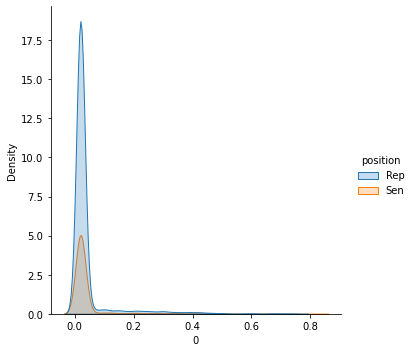

In [25]:
# Visualization- Topic 0 
sns.displot(df_w_topics, x=df_w_topics[0], hue = "position", kind = 'kde', fill = 'true')
plt.show()

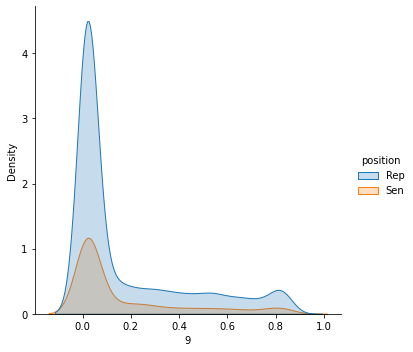

In [26]:
# Visualization- Topic 9
sns.displot(df_w_topics, x=df_w_topics[9], hue = "position", kind = 'kde', fill = 'true')
plt.show()

## The visualizations show that the topics would NOT be good candidates to pass to a supervised learning algorithm if we were interested in predicting the position(senate/representative).

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## 1) Exploration: Overall

In [40]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['tokens'].head()

0    All OH14 salutes Patrolman St Clair 👮 ‍ ♂ ️ QT...
1    In Case You Missed It Bipartisanship works – b...
2     Wishing happy Passover celebrating Seder tonight
3    RT WhiteHouse President realDonaldTrump signed...
4    I sent letter demanding Administration stop pl...
Name: tokens, dtype: object

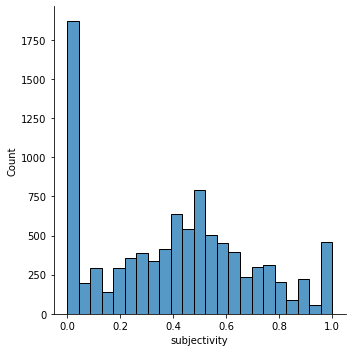

In [41]:
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

In [52]:
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,subjectivity
0,637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",All OH14 salutes Patrolman St Clair 👮 ‍ ♂ ️ QT...,0.0,0.0
1,148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",In Case You Missed It Bipartisanship works – b...,0.0,0.0
2,373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869",Wishing happy Passover celebrating Seder tonight,0.0,1.0
3,811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",RT WhiteHouse President realDonaldTrump signed...,0.0,0.0
4,582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",I sent letter demanding Administration stop pl...,0.0,1.0


##   Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Although the overall distribution is normal, more tweets were factual information(subjectivity ==0) compared to opinions(subjectivity ==1).

## 2) Choose two legislators, one liberal and one conservative

In [28]:
# Republican: David Joyce
congress_tweets_R.head()


,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[All, OH14, salutes, Patrolman, St, Clair, 👮, ..."
3,811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[RT, WhiteHouse, President, realDonaldTrump, s..."
6,832508,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[RT, HouseGOP, Its, time, holding, China, acco..."
7,586426,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[RT, wdtnews, With, confirmed, COVID19, cases,..."
13,156787,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[There, way, Eric, Swalwell, continue, serve, ..."


In [61]:
congress_tweets_DavidJoyce = congress_tweets['text'][0]
print(congress_tweets_DavidJoyce)


All of #OH14 salutes you, Patrolman St. Clair! 👮‍♂️ https://twitter.com/fox8news/status/1182779635840495622 QT @fox8news 5-year-old battling cancer becomes Bainbridge police officer for the day http://fox8.com/2019/10/11/5-year-old-battling-cancer-becomes-bainbridge-police-officer-for-the-day/ via @RooseveltLFOX8


In [62]:
congress_tweets_DavidJoyce = "All of #OH14 salutes you, Patrolman St. Clair! 👮‍♂️ https://twitter.com/fox8news/status/1182779635840495622 QT @fox8news 5-year-old battling cancer becomes Bainbridge police officer for the day http://fox8.com/2019/10/11/5-year-old-battling-cancer-becomes-bainbridge-police-officer-for-the-day/ via @RooseveltLFOX8"
print("overall subjectivity score for David Joyce(Republican) is", TextBlob(congress_tweets_DavidJoyce).sentiment.subjectivity)
for word in congress_tweets_DavidJoyce.split():
    print(word, TextBlob(word).sentiment.subjectivity)

overall subjectivity score for David Joyce(Republican) is 0.0
All 0.0
of 0.0
#OH14 0.0
salutes 0.0
you, 0.0
Patrolman 0.0
St. 0.0
Clair! 0.0
👮‍♂️ 0.0
https://twitter.com/fox8news/status/1182779635840495622 0.0
QT 0.0
@fox8news 0.0
5-year-old 0.0
battling 0.0
cancer 0.0
becomes 0.0
Bainbridge 0.0
police 0.0
officer 0.0
for 0.0
the 0.0
day 0.0
http://fox8.com/2019/10/11/5-year-old-battling-cancer-becomes-bainbridge-police-officer-for-the-day/ 0.0
via 0.0
@RooseveltLFOX8 0.0


## The overall subjectivity score for David Joyce(Republican) is 0.0

In [44]:
# Democrat: Josh Harder
congress_tweets_D.head()


,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
1,148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[In, Case, You, Missed, It, Bipartisanship, wo..."
2,373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[Wishing, happy, Passover, celebrating, Seder,..."
4,582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[I, sent, letter, demanding, Administration, s..."
5,860085,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[The, President, attacks, Rep, Ilhan, dishones..."
8,83341,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[RT, SVLeadershipGrp, We, game, changers, acce..."


In [48]:
congress_tweets_JoshHarder = congress_tweets['text'][1]
print(congress_tweets_JoshHarder)

In Case You Missed It: Bipartisanship works – and now my bill to eradicate swamp rats is becoming law!
https://www.turlockjournal.com/news/government/president-to-sign-harders-nutria-bill-into-law/


In [49]:
congress_tweets_JoshHarder = "In Case You Missed It: Bipartisanship works – and now my bill to eradicate swamp rats is becoming law! https://www.turlockjournal.com/news/government/president-to-sign-harders-nutria-bill-into-law/"
print("overall subjectivity score for Josh Harder(Democrat) is", TextBlob(congress_tweets_JoshHarder).sentiment.subjectivity)
for word in congress_tweets_JoshHarder.split():
    print(word, TextBlob(word).sentiment.subjectivity)

overall subjectivity score for Josh Harder(Democrat) is 0.8500000000000001
In 0.0
Case 0.0
You 0.0
Missed 0.0
It: 0.0
Bipartisanship 0.0
works 0.0
– 0.0
and 0.0
now 0.0
my 0.0
bill 0.0
to 0.0
eradicate 0.0
swamp 0.0
rats 0.0
is 0.0
becoming 0.8500000000000001
law! 0.0
https://www.turlockjournal.com/news/government/president-to-sign-harders-nutria-bill-into-law/ 0.0


## The overall subjectivity score for Josh Harder(Democrat) is 0.85

## 3-1)  compare Democrats v. Republicans 

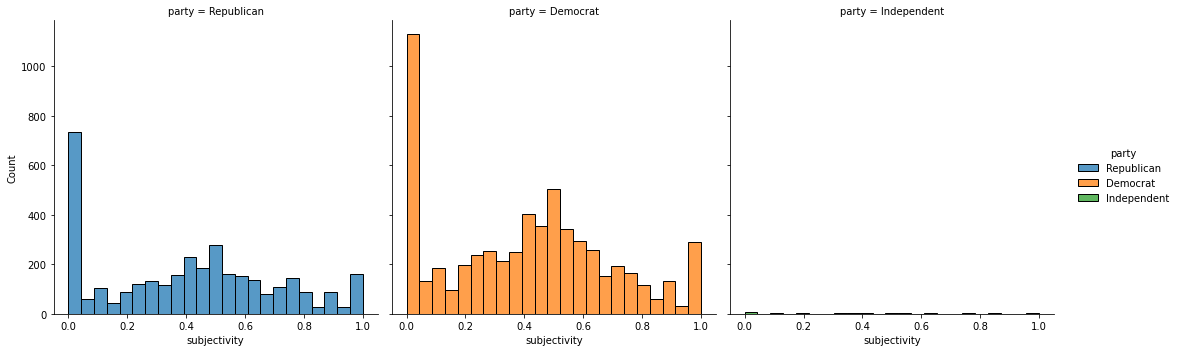

In [66]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

## Democrats tend to post more factual information(subjectivity ==0) than republicans

## 3-2) compare Senators v. Representatives 

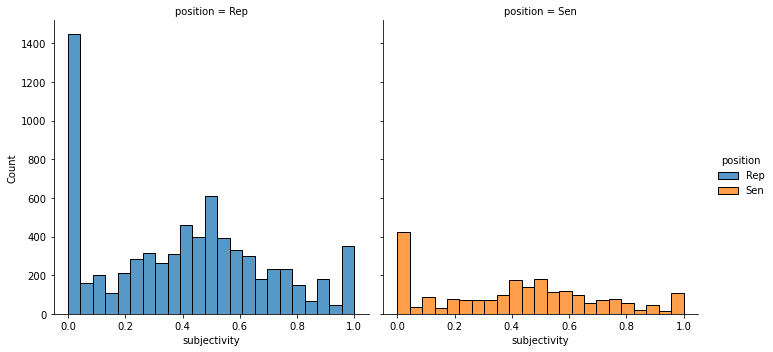

In [67]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

## Representatives tend to post more factual information(subjectivity ==0) than Senators

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [ ]:
# Engineered Features
...

### Bag-of-words or Tf-idf

In [ ]:
# Frequency Based featurization
...

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [ ]:
# embedding based featurization
...

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**